# Fitting and Conditioning

This notebook:

- samples from a random 5-component **2D** Gaussian mixture,
- fits `sklearn.mixture.GaussianMixture`,
- plots a scatter with fitted iso-density contours,
- conditions on `X=-5` and overlays the 1D conditional density `p(y | X=-5)` as an offset curve.

In [68]:
import numpy as np

import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')  # must be before pyplot import
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from cgmm import GMMConditioner

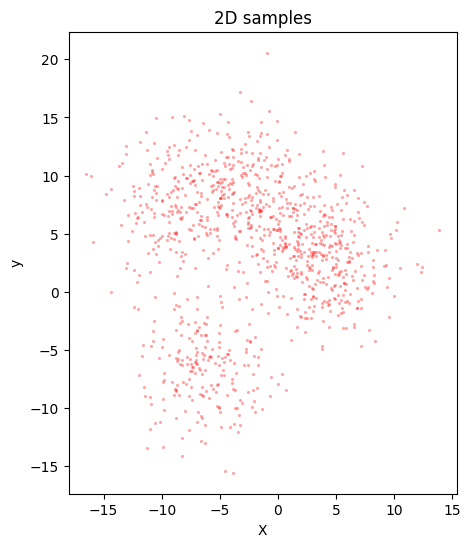

In [69]:
from sklearn.datasets import make_blobs

# Generate 2D samples
X, _ = make_blobs(
    n_samples=1000,
    centers=5,
    cluster_std=3,
    n_features=2,
    random_state=42,
)


# --- Scatter ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], s=5, alpha=0.35, linewidths=0, c='r')
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("2D samples")
ax.set_aspect("equal", adjustable="box")
plt.show()


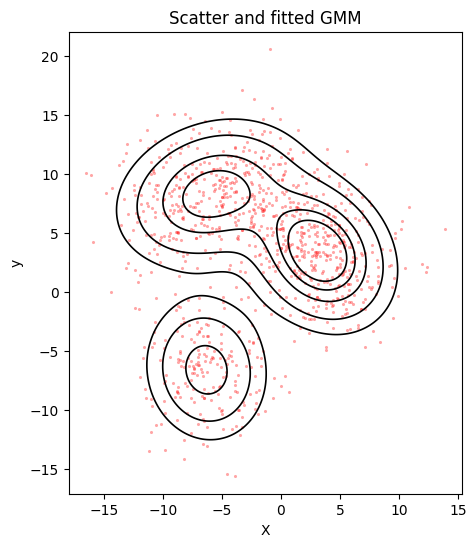

In [70]:
# --- 2) Fit a scikit-learn GMM ---
gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=0).fit(X)


# ---  Scatter + fitted HPD isolines ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], s=5, alpha=0.35, linewidths=0, c='r')

# Grid for density evaluation (for drawing lines)
pad = 1.5
x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 250),
    np.linspace(y_min, y_max, 250),
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = np.exp(gmm.score_samples(grid)).reshape(xx.shape)

# --- HPD levels from *sample* densities ---
# alphas = mass inside the contour
alphas = np.array([0.90, 0.75, 0.50, 0.25, 0.10])
sample_dens = np.exp(gmm.score_samples(X))
# For mass α, the density threshold is the (1-α) quantile of sample densities
levels = np.quantile(sample_dens, 1.0 - alphas)
levels = np.unique(np.sort(levels))
if levels.size < 2:  # safety fallback
    zmin, zmax = float(zz.min()), float(zz.max())
    if zmax <= zmin:
        zmax = zmin + 1e-12
    levels = np.linspace(zmin, zmax, 5)

# Draw isolines using a single color for clarity
ax.contour(xx, yy, zz, levels=levels, colors="k", linewidths=1.2)

ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Scatter and fitted GMM")
ax.set_aspect("equal", adjustable="box")
plt.show()


In [71]:
# --- 4) Condition on X = -5 ---
x0 = np.array([-5.0])
cond = GMMConditioner(gmm, cond_idx=[0]).precompute()
gmmy = cond.condition(x=x0)  # 1D GMM over y


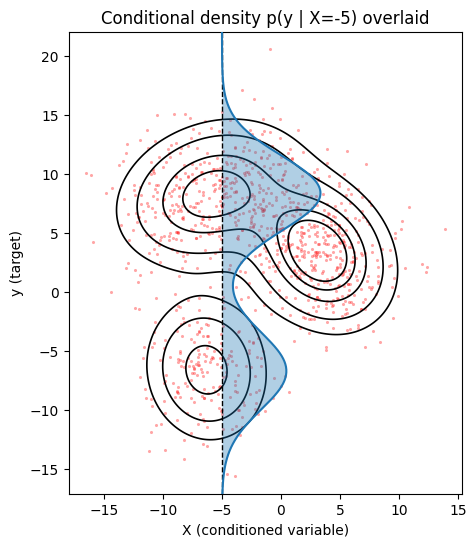

In [72]:
# --- 5) Overlay the conditional density p(y | X=1) as a filled ribbon ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], s=5, alpha=0.35, linewidths=0, c='r')

# Reuse HPD contours (levels) from Cell 3
zz = np.exp(gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.contour(xx, yy, zz, levels=levels, colors="k", linewidths=1.2)

# Vertical line at x = 1
ax.axvline(x0[0], linestyle="--", linewidth=1.0, color="k", zorder=3)

# Conditional density of y given X=1 (1D GMM)
y_grid = np.linspace(y_min, y_max, 500)[:, None]
pdf_y = np.exp(gmmy.score_samples(y_grid))

# Offset curve x = 1 + c * pdf(y | X=1)
scale = 0.25 * (x_max - x_min) / (pdf_y.max() + 1e-12)
x_offset = x0[0] + scale * pdf_y.ravel()

# Filled ribbon between the vertical line and the offset curve
ax.fill_betweenx(
    y_grid.ravel(),
    x0[0],              # left bound (vertical line)
    x_offset,           # right bound (offset curve)
    color="tab:blue",
    alpha=0.35,
    linewidth=0,
    zorder=2.8
)

# Optional outline of the offset curve for clarity
ax.plot(x_offset, y_grid.ravel(), linewidth=1.5, color="tab:blue", zorder=3)

ax.set_xlabel("X (conditioned variable)")
ax.set_ylabel("y (target)")
ax.set_title("Conditional density p(y | X=-5) overlaid")
ax.set_aspect("equal", adjustable="box")
plt.show()
